## Miscellaneous Plots

In [1]:
import numpy as np
import matplotlib
import pandas as pd
import gplately
import gplately.grids as grids
import gplately.tools as tools
import gplately.pygplates as pygplates
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.interpolate import RegularGridInterpolator
from scipy import ndimage
from IPython.display import clear_output
import copy
import os, glob
import warnings
%matplotlib inline
from joblib import Parallel, delayed
# plt.style.use('ggplot')

# common variables
extent_globe = [-180, 180, -90, 90]
earth_radius = 6371.009e3
earth_surface_area = 4.0*np.pi*earth_radius**2

# netCDF4 grid resolution
spacingX = 0.2
spacingY = 0.2
lon_grid = np.arange(extent_globe[0], extent_globe[1]+spacingX, spacingX)
lat_grid = np.arange(extent_globe[2], extent_globe[3]+spacingY, spacingY)

# reconstruction time steps and spacing
min_time = 0
max_time = 1000
timestep_size = 1
reconstruction_times = np.arange(max_time, min_time-1, -timestep_size)

In [2]:
# Change `folder_name`: a string to name a new sub-folder for a new set of Notebook 1 outputs; 
# useful for keeping track of reruns
folder_name = "Muller22_Mar2"

# Don't change this: directory to input files
output_directory = "../Outputs/{}/Videos/".format(folder_name)
os.makedirs(output_directory, exist_ok=True)
os.makedirs(output_directory+"cumulative_subducted_carbon", exist_ok=True)
os.makedirs("../Outputs/{}/Notebook08/figures/".format(folder_name), exist_ok=True)
os.makedirs(output_directory+"/figures", exist_ok=True)
os.makedirs(output_directory+"/csv", exist_ok=True)


### Read csv files

In [3]:
# MOR outgassing - 10Myr median filtered when saving csv
ridge_outflux_pd = pd.read_csv('../Outputs/{}/Notebook03/csv/03_ridge_outflux.csv'.format(folder_name), index_col=0, header=[0,1])
ridge_outflux_pd = ridge_outflux_pd.reindex(index=reconstruction_times)
ridge_outflux = ridge_outflux_pd.loc[:, (['outflux'], ['min', 'mean', 'max'])].to_numpy()
ridge_outflux_min = ridge_outflux_pd['outflux']['min'].to_numpy()
ridge_outflux_mean = ridge_outflux_pd['outflux']['mean'].to_numpy()
ridge_outflux_max = ridge_outflux_pd['outflux']['max'].to_numpy()

lithosphere_influx = ridge_outflux_pd.loc[:, (['influx'], ['min', 'mean', 'max'])].to_numpy()
lithosphere_influx_min = ridge_outflux_pd['influx']['min'].to_numpy()
lithosphere_influx_mean = ridge_outflux_pd['influx']['mean'].to_numpy()
lithosphere_influx_max = ridge_outflux_pd['influx']['max'].to_numpy()

# plate influx - 10Myr median filtered
plate_influx = pd.read_csv('../Outputs/{}/Notebook02/csv/02_plate_influx.csv'.format(folder_name), index_col=0, header=[0,1])
plate_influx = plate_influx.reindex(index=reconstruction_times)
sediments_influx    = plate_influx.loc[:, (['sediments'], ['min', 'mean', 'max'])].to_numpy()
serpentinite_influx = plate_influx.loc[:, (['serpentinite_total'], ['min', 'mean', 'max'])].to_numpy()
crust_influx        = plate_influx.loc[:, (['crust'], ['min', 'mean', 'max'])].to_numpy()
upper_plate_influx  = sediments_influx + serpentinite_influx + crust_influx
carbon_plate_influx = plate_influx.loc[:, (['serpentinite_total', 'crust', \
                                                    'lithosphere'], \
                                                   ['min', 'mean', 'max'])].to_numpy()

# subduction_outgassing - 10Myr median filtered (this depends on a 10-myr filtered output from 02_subducted_carbon)
subduction_outflux_pd = pd.read_csv('../Outputs/{}/Notebook03/csv/03_slab_outflux.csv'.format(folder_name), index_col=0, header=[0,1])
subduction_outflux_pd = subduction_outflux_pd.reindex(index=reconstruction_times)
subduction_outflux = subduction_outflux_pd.loc[:, (['outflux_sediments', 'outflux_intrusive', \
                                                    'outflux_volcanics', 'outflux_mantlelit'], \
                                                   ['min', 'mean', 'max'])].to_numpy()

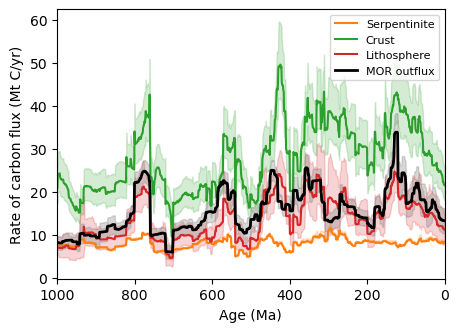

In [4]:
carbon_components = ["Serpentinite", "Crust", "Lithosphere"]


fig = plt.figure(figsize=(5,3.5))
ax = fig.add_subplot(111, xlabel='Age (Ma)', ylabel='Rate of carbon flux (Mt C/yr)', xlim=[1000,0])
# ax.set_yscale('log')


for c, component in enumerate(carbon_components):
    ax.fill_between(reconstruction_times,
                    carbon_plate_influx[:,3*c+0],
                    carbon_plate_influx[:,3*c+2],
                    color='C{}'.format(c+1), alpha=0.2)
    label = str(component)
#     if component == "Serpentinite":
#         label += ' (MOR)'
    ax.plot(reconstruction_times, carbon_plate_influx[:,3*c+1], c="C{}".format(c+1), label=label)
    
ax.fill_between(reconstruction_times,
                ridge_outflux_min,
                ridge_outflux_max,
                color='0.5', alpha=0.3)
ax.plot(reconstruction_times, ridge_outflux_mean, c='k', linewidth=2, label='MOR outflux')
    
ax.legend(prop={'size': 8})

fig.savefig(output_directory+"plate_in-outflux_comparison_sameaxes.pdf", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"plate_in-outflux_comparison_sameaxes.svg", bbox_inches='tight', dpi=300)
fig.savefig(output_directory+"plate_in-outflux_comparison_sameaxes.png", bbox_inches='tight', dpi=300)

## Diamonds

In [5]:
diamond_age, diamond_lon, diamond_lat = np.loadtxt(
    './diamonds_age_lon_lat_country_Guiliani_2019_250-0_North_America.txt', usecols=(0,1,2), unpack=True)

mask_diamonds = diamond_lon < 0
diamond_age = diamond_age[mask_diamonds]
diamond_lon = diamond_lon[mask_diamonds]
diamond_lat = diamond_lat[mask_diamonds]

In [6]:
# total subducted carbon
output_cdf_filename = "../Outputs/{}/Notebook02/smoothed_cumulative_subducted_carbon/300km/{}/mean/cumulative_subducted_carbon_{}_0.nc"

# this relies on a consistent folder structure - don't meddle!
carbon_components = ["Sediment", "Mantle"]


cumulative_subducted_carbon = []

for carbon_component in carbon_components:
    carbon_grid = grids.read_netcdf_grid(output_cdf_filename.format(folder_name, carbon_component, carbon_component.lower()))
    
    carbon_grid = np.nan_to_num(carbon_grid.data)
    
    cumulative_subducted_carbon.append( carbon_grid )


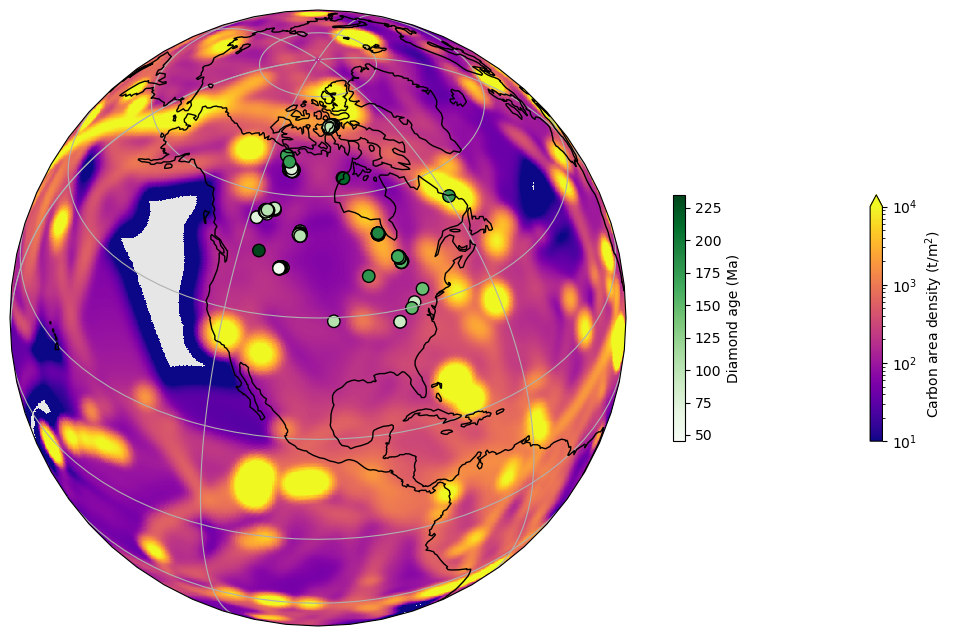

In [7]:
# total subducted carbon
proj = ccrs.NearsidePerspective(-100,40)
reconstruction_time = 0


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = np.sum(cumulative_subducted_carbon, axis=0)*1e6
lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
lognorm_cmap.set_bad((1,1,1), alpha=0)
im = ax.imshow(data, extent=extent_globe, origin='lower', cmap=lognorm_cmap,
norm=mcolors.LogNorm(vmin=1e1, vmax=1e4), transform=ccrs.PlateCarree(), interpolation='nearest')

sc = ax.scatter(diamond_lon, diamond_lat, c=diamond_age, s=80, edgecolor='k', 
                cmap='Greens', transform=ccrs.PlateCarree())

# add_continents(ax, reconstruction_time, facecolor='0.7', zorder=0)
# add_coastlines(ax, reconstruction_time, facecolor='w', alpha=0.25, zorder=2)
# add_ridges(ax, reconstruction_time, facecolor='none', edgecolor='k', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
# add_trenches(ax, reconstruction_time, zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='Carbon area density (t/m$^2$)', extend='max')
fig.colorbar(sc, shrink=0.4, label='Diamond age (Ma)')

fig.savefig("../Outputs/{}/Notebook08/figures/diamond_distribution_total_carbon.pdf".format(folder_name), dpi=300, bbox_inches='tight')

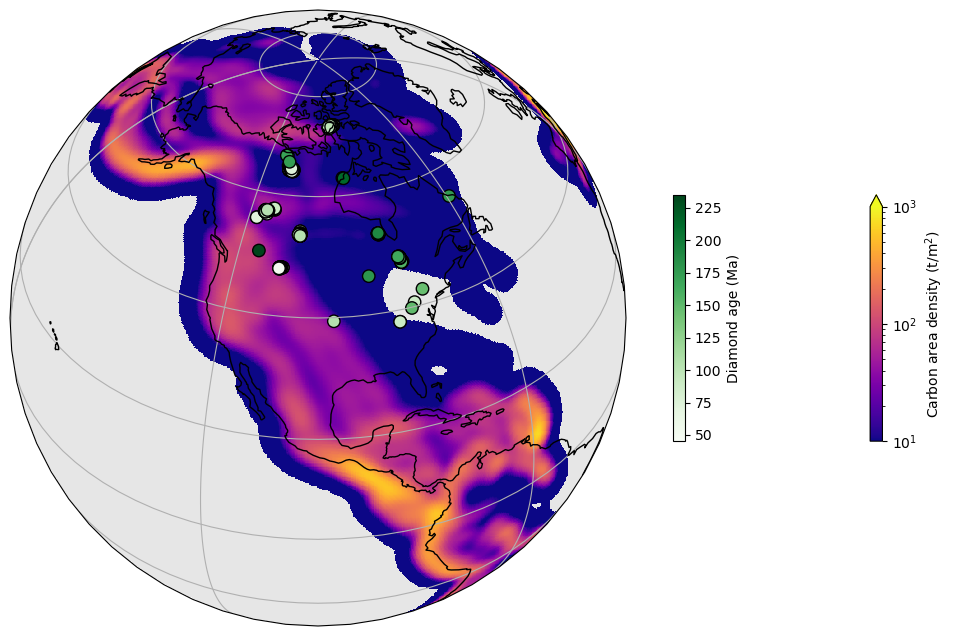

In [8]:
# total subducted carbon
proj = ccrs.NearsidePerspective(-100,40)
reconstruction_time = 0


fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection=proj)
ax.set_global()

ax.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

data = cumulative_subducted_carbon[0]*1e6
lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('plasma'))
lognorm_cmap.set_bad((1,0,1), alpha=0)
im = plt.imshow(data, extent=extent_globe, origin='lower', cmap='plasma', 
                norm=mcolors.LogNorm(vmin=1e1, vmax=1e3), transform=ccrs.PlateCarree() , interpolation='nearest')

sc = ax.scatter(diamond_lon, diamond_lat, c=diamond_age, s=80, edgecolor='k', 
                cmap='Greens', transform=ccrs.PlateCarree())

# add_continents(ax, reconstruction_time, facecolor='0.7', zorder=0)
# add_coastlines(ax, reconstruction_time, facecolor='w', alpha=0.25, zorder=2)
# add_ridges(ax, reconstruction_time, facecolor='none', edgecolor='k', linewidth=1.5, zorder=2)
# add_quiver(ax, reconstruction_time, color='k', alpha=0.33, zorder=3)
# add_trenches(ax, reconstruction_time, zorder=2)

ax.coastlines(zorder=3)
ax.gridlines()
fig.colorbar(im, shrink=0.4, label='Carbon area density (t/m$^2$)', extend='max')
fig.colorbar(sc, shrink=0.4, label='Diamond age (Ma)')

fig.savefig("../Outputs/{}/Notebook08/figures/diamond_distribution_sedimentary_carbon.pdf".format(folder_name), dpi=300, bbox_inches='tight')

## Movies of convergence rates ONLY where continental arcs are

A set of global maps (500, 400, 300, 200, 100, 0) and the video from 540-0 in 1 my intervals showing plate boundaries, velocity arrows, subduction zones with teeth and continent outlines.

Using “plasma” colour to show convergence rates ONLY where continental arcs are, ie where subduction zones are adjacent to continental crust, limited from 0-10 cm/yr.
No MOR spreading rates and age of the ocean floor. Show carbonate platform locations through time, ie not “active” platforms but all platforms that exist at a given time


# Cumulative subducted carbon through time

Below, we plot comparisons of cumulative subducted carbon between the Merdith2021 and the Muller2022 models through time, and summarise this in a video. 

In [9]:
# Use GPlately's DataServer to get a rotation model, topology features and static polygons
gdownload2 = gplately.download.DataServer("Muller2022", verbose=False)
rotation_model_m22, topology_features_m22, static_polygons_m22 = gdownload2.get_plate_reconstruction_files()
model_m22 = gplately.PlateReconstruction(rotation_model_m22, topology_features_m22, static_polygons_m22)

# Use GPlately's DataServer to get coastlines and continents
coastlines_m22, continents_m22, COBs_m22 = gdownload2.get_topology_geometries()
gplot_m22 = gplately.PlotTopologies(plate_reconstruction=model_m22, time=0.0, coastlines=coastlines_m22, continents=continents_m22)

Load kimberlites, lamproites and carbonatites...

In [10]:
import pandas as pd

kimberlites = "./kimberlites_Guiliani_Pearson_2019.txt"
lamproites = "./lamproites_georoc_25Aug2023.txt"
carbonatites = "./carbonatites_Wooley_Kiarsgaard_2008.txt"

# Read deposit txt files and ignore deposits older than 1Ga
kimberlites_pd = pd.read_table(kimberlites, names=["Longitude", "Latitude", "Age"]).iloc[1:].astype(float)
kimberlites_pd = kimberlites_pd.loc[kimberlites_pd["Age"] <= 1000. ]
k_lats = kimberlites_pd["Latitude"].astype(float).to_numpy()
k_lons = kimberlites_pd["Longitude"].astype(float).to_numpy()
k_ages = kimberlites_pd["Age"].astype(float).to_numpy()

lamproites_pd = pd.read_table(lamproites, index_col=False, names=["Longitude", "Latitude", "Age"]).iloc[1:].astype(float)
lamproites_pd = lamproites_pd.loc[lamproites_pd["Age"] <= 1000. ]
l_lats = lamproites_pd["Latitude"].astype(float).to_numpy()
l_lons = lamproites_pd["Longitude"].astype(float).to_numpy()
l_ages = lamproites_pd["Age"].astype(float).to_numpy()

carbonatites_pd = pd.read_table(carbonatites, names=["Longitude", "Latitude", "Age"]).iloc[1:].replace(',', '.', regex=True).astype(float)
carbonatites_pd = carbonatites_pd.loc[carbonatites_pd["Age"] <= 1000. ]
c_lats = carbonatites_pd["Latitude"].astype(float).to_numpy()
c_lons = carbonatites_pd["Longitude"].astype(float).to_numpy()
c_ages = carbonatites_pd["Age"].astype(float).to_numpy()


In [11]:
# Kimberlites
kimberlites_fc_m22 = gplately.Points(model_m22, k_lons, k_lats)
for i, feature in enumerate(kimberlites_fc_m22.features):
    feature.set_valid_time(k_ages[i], 0)
    
kimberlites_fc = pygplates.FeatureCollection(kimberlites_fc_m22.features)
kimberlites_fc.write('./kimberlites_Guiliani_Pearson_2019.gpml')
    
    
# Lamproites
lamproites_fc_m22 = gplately.Points(model_m22, l_lons, l_lats)
for i, feature in enumerate(lamproites_fc_m22.features):
    feature.set_valid_time(l_ages[i], 0)
lamproites_fc = pygplates.FeatureCollection(lamproites_fc_m22.features)
lamproites_fc.write('./lamproites_georoc_25Aug2023.gpml')


# Carbonatites
carbonatites_fc_m22 = gplately.Points(model_m22, c_lons, c_lats)
for i, feature in enumerate(carbonatites_fc_m22.features):
    feature.set_valid_time(c_ages[i], 0)
    
carbonatites_fc = pygplates.FeatureCollection(carbonatites_fc_m22.features)
carbonatites_fc.write('./carbonatites_Wooley_Kiarsgaard_2008.gpml')

/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/gplately/pygplates.py:617: ImportWarning: 
FeatureCollection: No filename associated with <class 'list'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates
/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/gplately/pygplates.py:617: ImportWarning: 
FeatureCollection: No filename associated with <class 'list'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates
/Users/laurenilano/opt/miniconda3/envs/januarytwo/lib/python3.9/site-packages/gplately/pygplates.py:617: ImportWarning: 
FeatureCollection: No filename associated with <class 'list'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


In [12]:
gplots = [gplot_m22]
models = [model_m22]

labels = ["Muller et al. (2022)"]
short_label = ["Muller2022"]
kimberlites = [kimberlites_fc_m22]
lamproites = [lamproites_fc_m22]
carbonatites = [carbonatites_fc_m22]

def reconstruct_deposits(i, time):
    """ Reconstruct the coordinates of deposits through time while also keeping track
    of their valid times
    """
    # RECONSTRUCT KIMBERLITES
    reconstructed_features = models[i].reconstruct(
            kimberlites[i].features, time, from_time=0, anchor_plate_id=0)
    
    curr_klon, curr_klat = gplately.tools.extract_feature_lonlat(reconstructed_features)
    klat_fromage = [f.get_feature().get_valid_time()[0] for f in reconstructed_features]

    # RECONSTRUCT LAMPROITES
    curr_llon, curr_llat = lamproites[i].reconstruct(time, return_array=True)
    
    reconstructed_features = models[i].reconstruct(
            lamproites[i].features, time, from_time=0, anchor_plate_id=0)
    
    curr_llon, curr_llatt = gplately.tools.extract_feature_lonlat(reconstructed_features)
    llat_fromage = [f.get_feature().get_valid_time()[0] for f in reconstructed_features]
    
    # RECONSTRUCT CARBONATITES
    curr_clon, curr_clat = carbonatites[i].reconstruct(time, return_array=True)
    
    reconstructed_features = models[i].reconstruct(
            carbonatites[i].features, time, from_time=0, anchor_plate_id=0)
    
    curr_clon, curr_clatt = gplately.tools.extract_feature_lonlat(reconstructed_features)
    clat_fromage = [f.get_feature().get_valid_time()[0] for f in reconstructed_features]

    return curr_klon, curr_klat, klat_fromage, curr_llon, curr_llat, llat_fromage, \
        curr_clon, curr_clat, clat_fromage


In [13]:
# Obtain latitudes and longitudes of kimberlites, lamproites and carbonatites in parallel. Running 
# pygplates in parallel requires the 'threading' backend which is incompatible
# with reading netCDFs so this is done in a separate cell to the plotting cell. 

# We reconstruct from 0-1000 so we can make use of indexing
deposit_times = np.arange(min_time, max_time+1, 1)

m22_deposit_coords = Parallel(n_jobs=-2, verbose=1, backend='threading') \
(delayed(reconstruct_deposits) \
 (0, time) for time in deposit_times)

m22_deposit_coords = np.array(m22_deposit_coords, dtype=object)
m22_curr_klon = m22_deposit_coords[:,0]
m22_curr_klat = m22_deposit_coords[:,1]
m22_k_fromages = m22_deposit_coords[:,2]
m22_curr_llon = m22_deposit_coords[:,3]
m22_curr_llat = m22_deposit_coords[:,4] 
m22_l_fromages = m22_deposit_coords[:,5]
m22_curr_clon = m22_deposit_coords[:,6]
m22_curr_clat = m22_deposit_coords[:,7] 
m22_c_fromages = m22_deposit_coords[:,8] 


all_klons = [m22_curr_klon]
all_klats = [m22_curr_klat]
all_k_fromages = [m22_k_fromages]
all_llons = [m22_curr_llon]
all_llats = [m22_curr_llat]
all_l_fromages = [m22_l_fromages]
all_clons = [m22_curr_clon]
all_clats = [m22_curr_clat]
all_c_fromages = [m22_c_fromages]


[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 9 concurrent workers.
[Parallel(n_jobs=-2)]: Done  32 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-2)]: Done 182 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done 432 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done 782 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-2)]: Done 1001 out of 1001 | elapsed:   11.5s finished


### Individual plots

In [14]:
smoothed_cumulative_grid = "../Outputs/{}/Notebook02/smoothed_cumulative_subducted_carbon/{}km/{}/{}/cumulative_subducted_carbon_{}_{}.nc"
    
def plot_cumulative_subducted_carbon(i, component, quantity, time, folder_names, distance_km=300, save_fig=False):
    
    """ i = 0 for Merdith2021, i = 1 for Muller2022
    """
    
    folder_name = folder_names[i]
    
    time_extension = 2.
    
    cumulative_grids = []
    
    
    # Read the subducted carbon grid for the current component (c) and quantity (i). 
    cumulative_carbon_grid = grids.read_netcdf_grid(
        smoothed_cumulative_grid.format(folder_name, distance_km, component, quantity, component.lower(), time)
    )

    #cumulative_carbon_grid_filled = grids.fill_raster(cumulative_carbon_grid)
    cumulative_carbon_grid_filled = cumulative_carbon_grid.data
    cumulative_carbon_grid_filled = np.nan_to_num(cumulative_carbon_grid_filled)

    # Plot this component's cumulative contribution 
    data = cumulative_carbon_grid_filled*1e6
    cumulative_grids.append(data)
        
    #cumulative_carbon_grid_filled = grids.fill_raster(cumulative_carbon_grid)
    cumulative_carbon_grid_filled = cumulative_carbon_grid.data
    cumulative_carbon_grid_filled = np.nan_to_num(cumulative_carbon_grid_filled)

    # Plot this component's cumulative contribution 
    data = cumulative_carbon_grid_filled*1e6
    
    proj = ccrs.Mollweide(central_longitude=60)
    
    fig = plt.figure(figsize=(20,8))
    ax3 = fig.add_subplot(111, projection=ccrs.Mollweide(central_longitude=60))

    ax3.set_global()
        
    ax3.set_title("Cumulative subducted carbon \n {} - {}Ma \n {}".format(component.replace("_", " "), time, labels[i]), fontsize=15)

    ax3.imshow(np.array([[0.9,0.9],[0.9,0.9]]), extent=[-180,180,-180,180], cmap='gray', vmin=0, vmax=1,
          transform=ccrs.PlateCarree(), zorder=0)

    lognorm_cmap = copy.copy(matplotlib.cm.get_cmap('turbo'))
    lognorm_cmap.set_bad((1,1,1), alpha=0)

    if component == "Sediment" or component == "Crust":
        vmax = 1e3
    elif component == "Organic_Sediments":
        vmax = 1e2
    else:
        vmax = 1e4
        
    im = ax3.imshow(
        data, extent=extent_globe, origin='lower', cmap=lognorm_cmap, 
        norm=mcolors.LogNorm(vmin=1e1, vmax=vmax), alpha=0.7,

        transform=ccrs.PlateCarree(), interpolation='nearest'
    )

    gplots[i].time = time
    gplots[i].plot_coastlines(ax3, facecolor='w', alpha=0.46, zorder=2)
    gplots[i].plot_ridges(ax3, color='r', linewidth=1.5, zorder=2, label = "Ridges")
    gplots[i].plot_trenches(ax3, zorder=2, label = "Trenches with polarity teeth")
    gplots[i].plot_subduction_teeth(ax3, zorder=2)

    ids = []
    for feature in gplots[i].topologies:
        ids.append(feature.get_reconstruction_plate_id())

    for idd in np.unique(np.array(ids)):
        
        # There are some Muller2022 plate ID polygons through time 
        # that raise errors when plotted with geopandas. The conditions below
        # skip these polygons. They were manually identified.
        
        if (time == 649. or time == 650.) and str(idd) == "98046":
            continue
        elif (time in np.arange(283, 287,1)) and str(idd) == "701":
            continue
        elif time == 248. and str(idd) == "926":
            continue
        
        # If the time and current polygon is OK to plot...
        gplots[i].plot_plate_id(ax3, idd, facecolor="None", edgecolor='grey')

    ax3.gridlines(alpha=0.5)
    

    # PLOT KIMBERLITES
    # Since we reconstructed kimberlites from min to max time, time will equal its index
    curr_klon, curr_klat = all_klons[i][time], all_klats[i][time]
    ax3.scatter(
        curr_klon, curr_klat,
        marker="D", c='w', edgecolor='k', s=40, 
        transform=ccrs.PlateCarree(),
        zorder=6,
        label = "Kimberlites"
    )
    
    # If a deposit has just shown up at this timestep...
    new_dep_lon = []
    new_dep_lat = []
    for ind, dep_from_age in enumerate(all_k_fromages[i][time]):

        # Show deposit is about to show up 2myr before it shows up, and continue the alert 2Myr after
        # it shows up
        time_range = np.arange(dep_from_age-time_extension, dep_from_age+time_extension+1, 1)
        if int(time) in [int(t) for t in time_range]:

            # Get a list of these deposits
            new_dep_lon.append(curr_klon[ind])
            new_dep_lat.append(curr_klat[ind])

    if new_dep_lon:
        ax3.scatter(
            new_dep_lon, new_dep_lat,
            marker="D", c='r', edgecolor='k', s=120, 
            transform=ccrs.PlateCarree(),
            zorder=6,
            #label = "New Kimberlites"
        )

    # RECONSTRUCT AND PLOT LAMPROITES
    # Since we reconstructed lamproites from min to max time, time will equal its index
    curr_llon, curr_llat = all_llons[i][time], all_llats[i][time]
    ax3.scatter(
        curr_llon, curr_llat,
        marker="*", c='w', edgecolor='k', s=60, 
        transform=ccrs.PlateCarree(),
        zorder=6,
        label = "Lamproites"
    )

    # If a deposit has just shown up at this timestep...
    new_dep_lon = []
    new_dep_lat = []
    for ind, dep_from_age in enumerate(all_l_fromages[i][time]):

        # Show deposit is about to show up 2myr before it shows up, and continue the alert 2Myr after
        # it shows up
        time_range = np.arange(dep_from_age-time_extension, dep_from_age+time_extension+1, 1)
        if int(time) in [int(t) for t in time_range]:

            # Get a list of these deposits
            new_dep_lon.append(curr_llon[ind])
            new_dep_lat.append(curr_llat[ind])


    if new_dep_lon:
        ax3.scatter(
            new_dep_lon, new_dep_lat,
            marker="*", c='r', edgecolor='k', s=210, 
            transform=ccrs.PlateCarree(),
            zorder=6,
            #label = "New Lamproites"
        )
        
        
        
    # RECONSTRUCT AND PLOT CARBONATITES
    # Since we reconstructed lamproites from min to max time, time will equal its index
    curr_clon, curr_clat = all_clons[i][time], all_clats[i][time]
    ax3.scatter(
        curr_clon, curr_clat,
        marker="o", c='w', edgecolor='k', s=60, 
        transform=ccrs.PlateCarree(),
        zorder=6,
        label = "Carbonatites"
    )

    # If a deposit has just shown up at this timestep...
    new_dep_lon = []
    new_dep_lat = []
    for ind, dep_from_age in enumerate(all_c_fromages[i][time]):

        # Show deposit is about to show up 2myr before it shows up, and continue the alert 2Myr after
        # it shows up
        time_range = np.arange(dep_from_age-time_extension, dep_from_age+time_extension+1, 1)
        if int(time) in [int(t) for t in time_range]:

            # Get a list of these deposits
            new_dep_lon.append(curr_clon[ind])
            new_dep_lat.append(curr_clat[ind])

    if new_dep_lon:
        ax3.scatter(
            new_dep_lon, new_dep_lat,
            marker="o", c='r', edgecolor='k', s=210, 
            transform=ccrs.PlateCarree(),
            zorder=6,
            #label = "New Lamproites"
        )

        
        
    plt.colorbar(im, label='Carbon area density (t/m$^2$)', extend='max', shrink=0.5)
    ax3.legend(loc="lower right", bbox_to_anchor=[0.2, -0.1])
    
    if save_fig:
        fig.savefig(output_directory+"cumulative_subducted_carbon/cumulative_subducted_carbon_{}_{}_{}Ma.png".format(
            component, short_label[i], time), dpi=300, bbox_inches='tight'
        )
        plt.close()


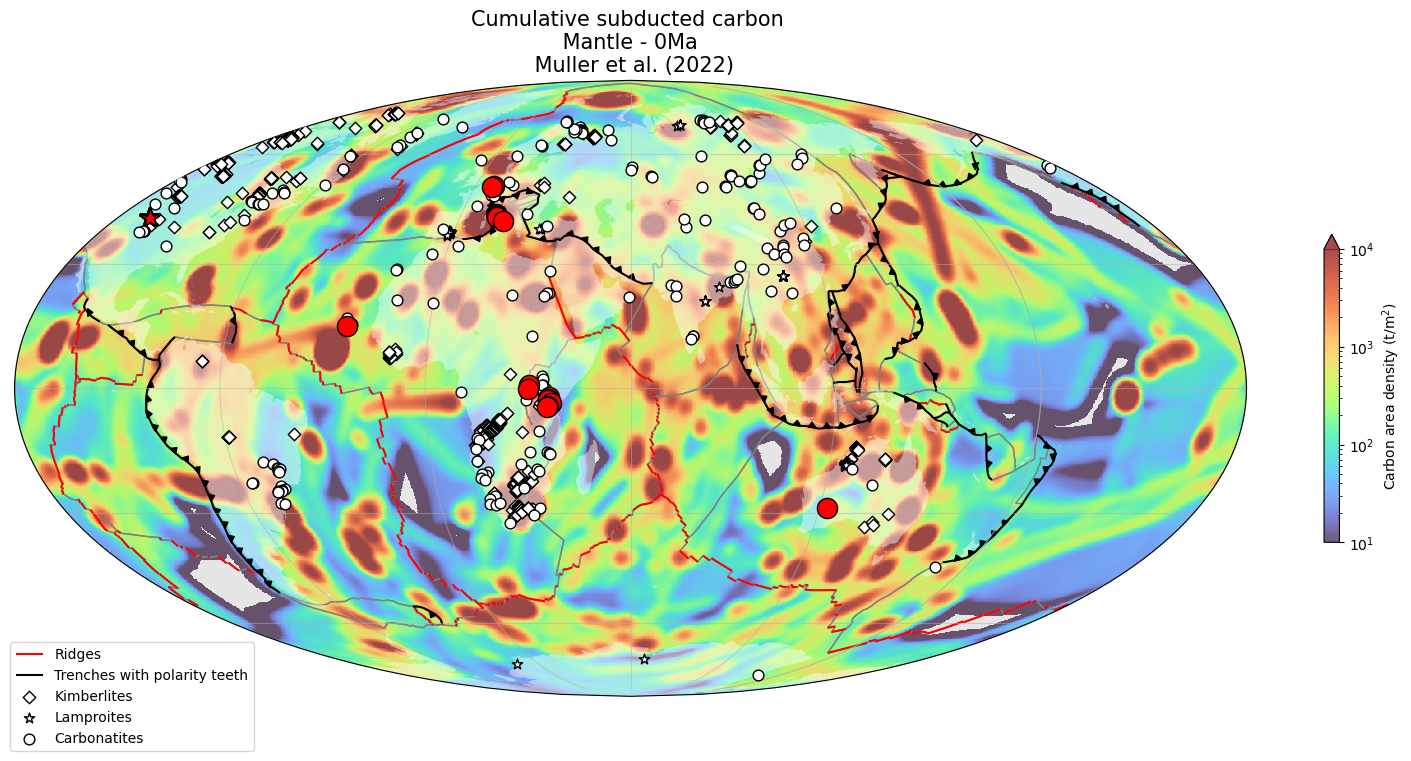

In [15]:
component = "Mantle"

time = 0
folder_names = [folder_name]
distance_km = 300
quantity="mean"

plot_cumulative_subducted_carbon(0, component, quantity, time, folder_names, distance_km=300)
    

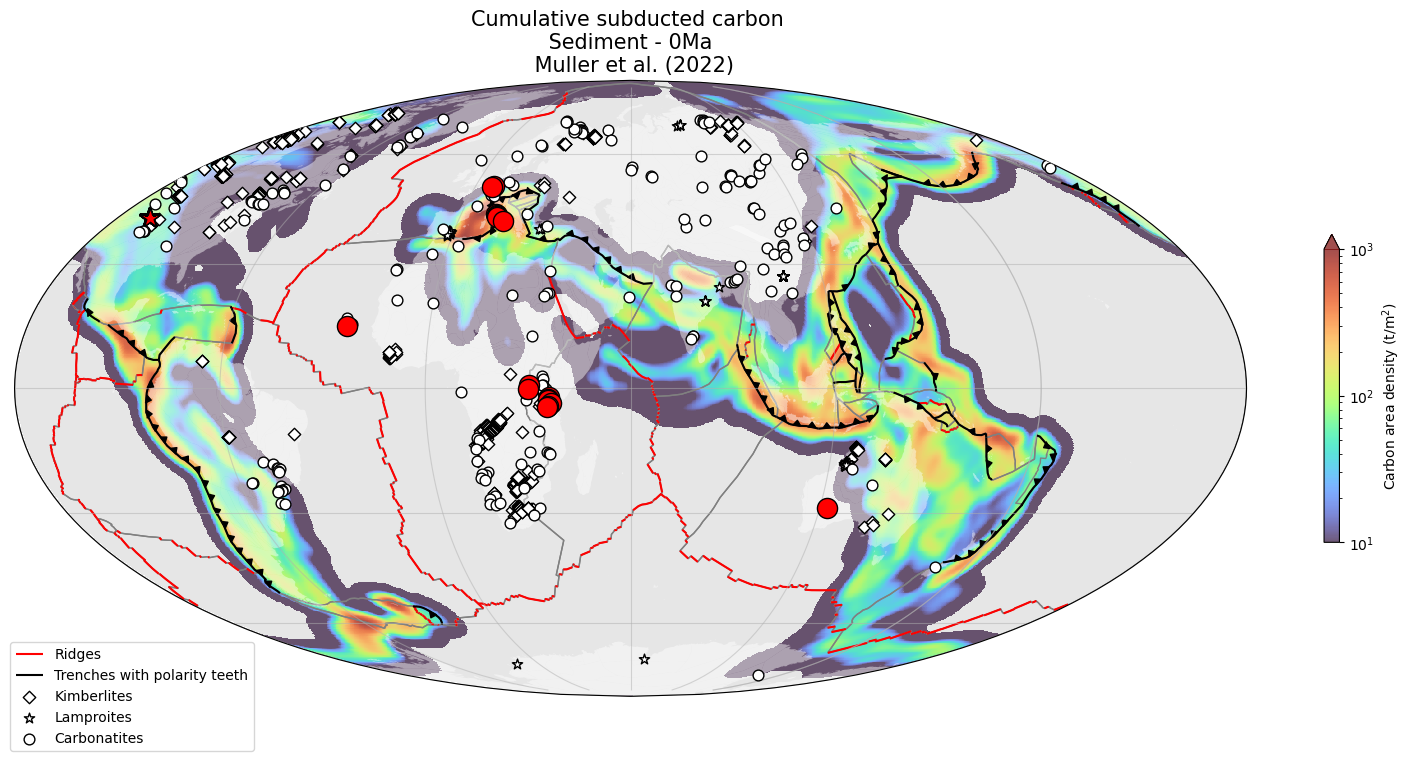

In [16]:
component = "Sediment"

time = 0
folder_names = [folder_name]
distance_km = 300
quantity="mean"

plot_cumulative_subducted_carbon(0, component, quantity, time, folder_names, distance_km=300)
    

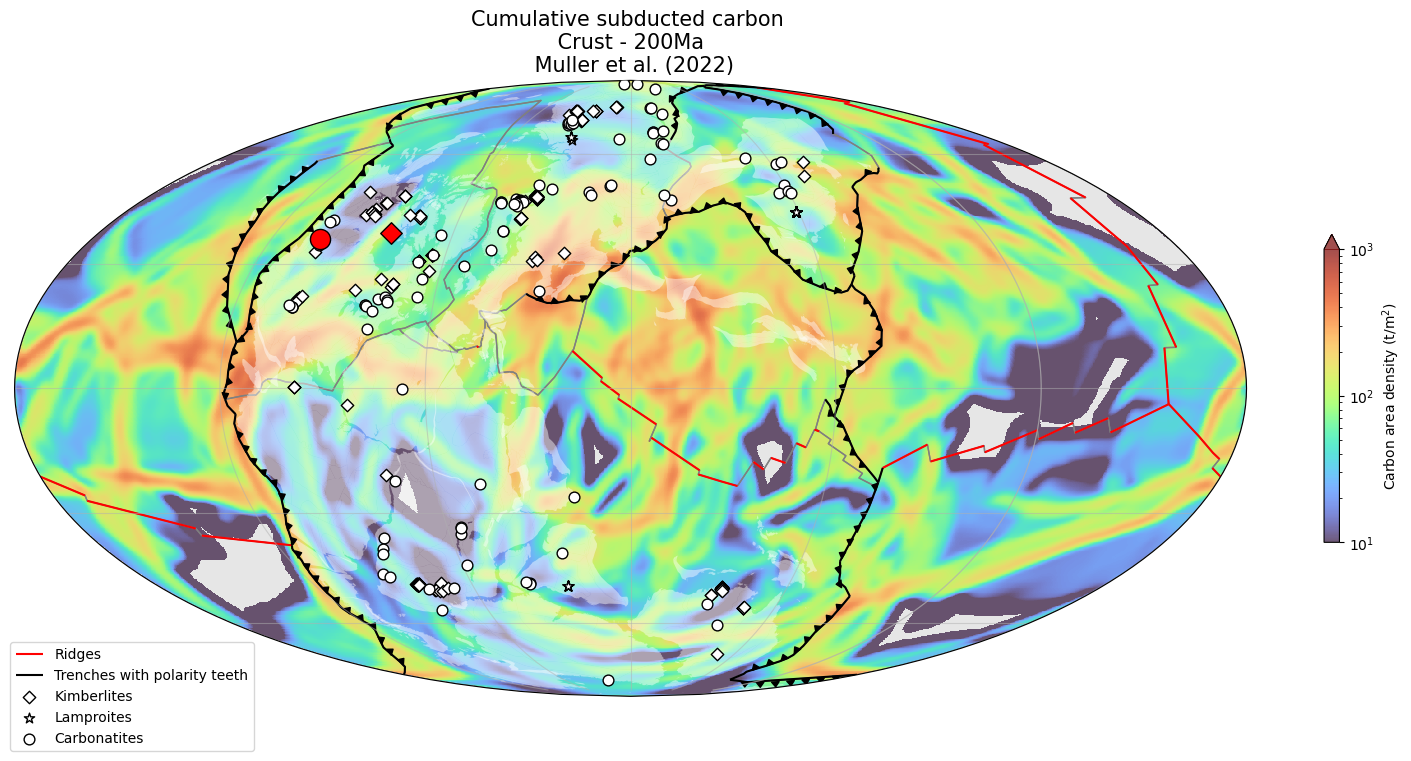

In [17]:
component = "Crust"
time = 200
distance_km = 300
quantity="mean"

plot_cumulative_subducted_carbon(0, component, quantity, time, folder_names, distance_km=300)

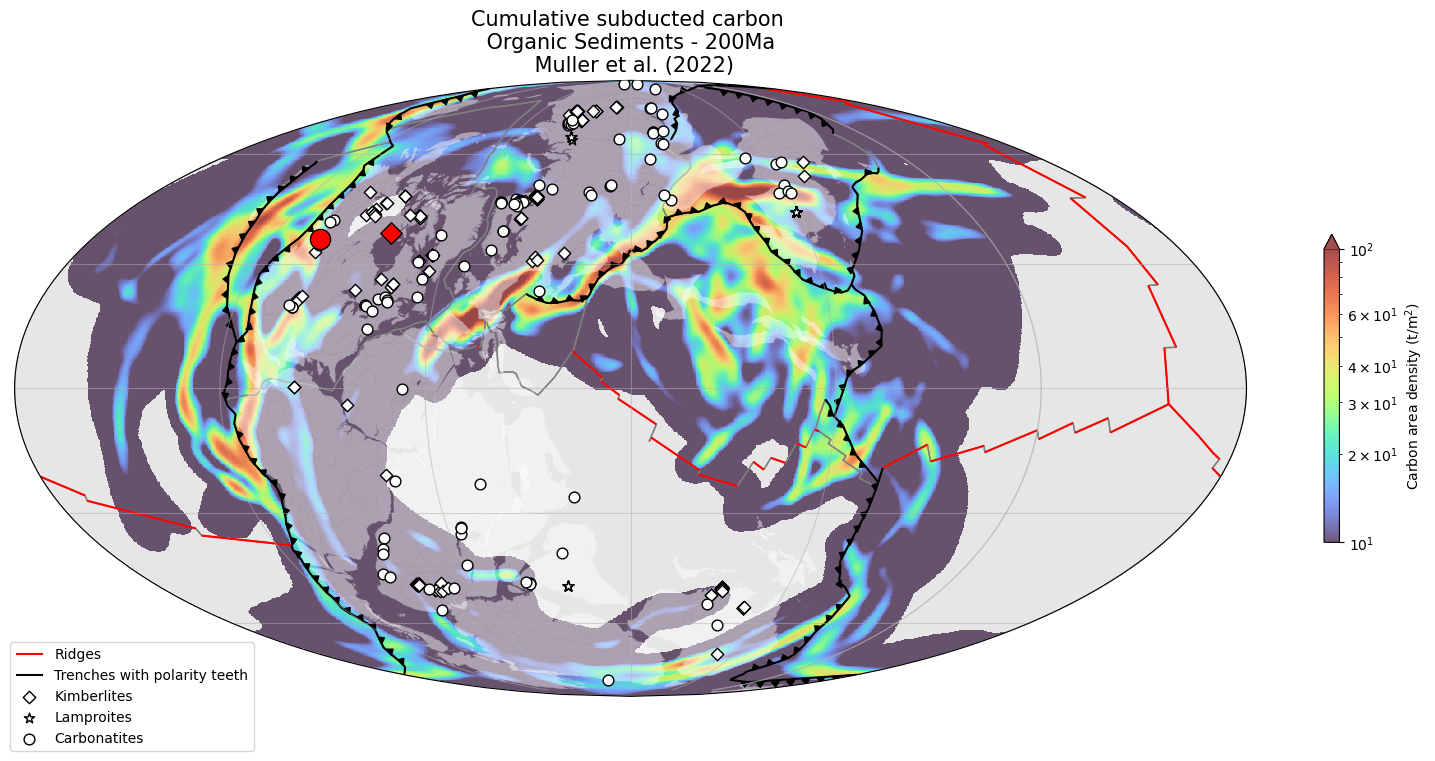

In [18]:
component = "Organic_Sediments"
time = 200
distance_km = 300
quantity="mean"

plot_cumulative_subducted_carbon(0, component, quantity, time, folder_names, distance_km=300)
    

In [19]:
carbon_components = ["Crust", "Mantle", "Sediment", "Organic_Sediments"]
folder_names = [folder_name]

for i, model in enumerate(labels):
    for c, component in enumerate(carbon_components):

        if component == "Sediment":
            plotting_times = np.arange(170, min_time-1, -timestep_size)
        elif component == "Organic_Sediments":
            plotting_times = np.arange(540, min_time-1, -timestep_size)
        else:
            plotting_times = np.arange(max_time, min_time-1, -timestep_size)

        distance_km = 300

        # Produce plots in a parallel routine
        parallel_slab_storage = Parallel(n_jobs=-3, verbose=1) \
        (delayed(plot_cumulative_subducted_carbon) \
         (i, component, "mean", time, folder_names, distance_km, save_fig=True) for time in plotting_times)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed: 38.6min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-3)]: Done 184 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-3)]: Done 434 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-3)]: Done 784 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-3)]: Done 1001 out of 1001 | elapsed: 40.2min finished
[Parallel(n_jobs=-3)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-3)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done 171 out of 171 | elapsed:  6.9min finish

In [20]:
import moviepy.editor as mpy

for i, model in enumerate(labels):
    for c, component in enumerate(["Crust", "Mantle", "Sediment", "Organic_Sediments"]):
    
        if component == "Sediment":
            plotting_times = np.arange(170, min_time-1, -timestep_size)
        elif component == "Organic_Sediments":
            plotting_times = np.arange(540, min_time-1, -timestep_size)
        else:
            plotting_times = np.arange(max_time, min_time-1, -timestep_size)

        frame_list = []
        for reconstruction_time in plotting_times:
            frame_list.append(
                output_directory+"/cumulative_subducted_carbon/cumulative_subducted_carbon_{}_{}_{}Ma.png".format(
                component, short_label[i], reconstruction_time)
            )

        clip = mpy.ImageSequenceClip(frame_list, fps=25)
        clip.write_gif(
            output_directory+"/cumulative_subducted_carbon_{}_{}.gif".format(component, short_label[i])
        )

        clip = mpy.VideoFileClip(
            output_directory+"/cumulative_subducted_carbon_{}_{}.gif".format(component, short_label[i])
        )

        clip.write_videofile(
            output_directory+"/cumulative_subducted_carbon_{}_{}.mp4".format(component, short_label[i]),
            codec='mpeg4'
        )

MoviePy - Building file ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Crust_Muller2022.gif with imageio.


Moviepy - Building video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Crust_Muller2022.mp4.
Moviepy - Writing video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Crust_Muller2022.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Crust_Muller2022.mp4
MoviePy - Building file ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Mantle_Muller2022.gif with imageio.


Moviepy - Building video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Mantle_Muller2022.mp4.
Moviepy - Writing video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Mantle_Muller2022.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Mantle_Muller2022.mp4
MoviePy - Building file ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Sediment_Muller2022.gif with imageio.


Moviepy - Building video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Sediment_Muller2022.mp4.
Moviepy - Writing video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Sediment_Muller2022.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Sediment_Muller2022.mp4
MoviePy - Building file ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Organic_Sediments_Muller2022.gif with imageio.


Moviepy - Building video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Organic_Sediments_Muller2022.mp4.
Moviepy - Writing video ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Organic_Sediments_Muller2022.mp4



Moviepy - Done !
Moviepy - video ready ../Outputs/Muller22_Mar2/Videos//cumulative_subducted_carbon_Organic_Sediments_Muller2022.mp4
